# url: https://qiita.com/NobuYoshi/items/2e44cbcc6df830c6538e

# 使用データ: https://www.kaggle.com/datasets/vijayuv/onlineretail

# 顧客のセグメント分析概要

顧客をある特性ごとに分割することで、優良顧客を見つけたり、効率的に広告を打つことなどができるようになります。

セグメント分けには性別や年齢などの属性を使う方法もありますが、ここでは購買履歴データを使用した２つの分析手法を扱います。

# デシル分析とは

顧客を、購入金額順に並べて10分割することでセグメント分けする方法です。

## RFM分析とは

以下３つの指標により顧客をセグメント分けする方法です。

Recency：直近何日前に利用したか

Frequency：ある期間中にどれくらいの頻度で利用したか

Monetary：ある期間中に利用した合計金額

# デシル分析の実装

## データの読み込み, EDA, 前処理

In [1]:
# 基本モジュールのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# データ読み込み
dtypes = {
    'InvoiceNo': 'object',
    'StockCode': 'object',
    'Description': 'object',
    'Quantity': 'int8',
    'UnitPrice': 'float64',
    'CustomerID': 'object',
    'Country': 'object'
}

# 'InvoiceDate'列をdatetime型に変換するためにparse_datesを使用
raw_data = pd.read_csv('/content/OnlineRetail.csv', dtype=dtypes, encoding='shift-jis', parse_dates=['InvoiceDate'])

In [3]:
# 概要確認
print(raw_data.shape)
raw_data.head(5)

# 各カラムを簡単に説明すると
# InvouceNo：発注番号
# StockCode：商品番号
# Description：商品説明
# Quantity：購入個数
# InvoiceDate：購入日時
# UnitPrice：商品単価
# CustomerID：顧客番号
# Country：国

# デシル分析では、Quantity, UnitPrice, CustomerIDを使用します。もう少しデータを調べてみると

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
# 欠損値などを確認
display(raw_data.isnull().sum())
raw_data.info()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int8          
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int8(1), object(5)
memory usage: 29.5+ MB


In [5]:
# 数値変数の統計量確認
display(raw_data.describe(include = 'all'))

# QuantityとUnitPrice一部に負の値が入っていることがわかります。
# 購入のキャンセル時などに負の値が入るなど何かしらのルールがあるみたいですが、今回は0以上のデータのみ使用することにします。
# また、CutomerIDが欠損したデータも除いておきます。

# クレンジング
data = raw_data.query('Quantity >= 0 & UnitPrice >= 0').dropna(axis=0, subset=['CustomerID'])

<ipython-input-5-d0ae0379f940>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(raw_data.describe(include = 'all'))


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829,541909
unique,25900,4070,4223,NaN,23260,NaN,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,17841,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,7983,495478
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,7.356043,NaN,4.611114,NaN,NaN
std,NaN,NaN,NaN,15.706513,NaN,96.759853,NaN,NaN
min,NaN,NaN,NaN,-128.000000,NaN,-11062.060000,NaN,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,NaN,NaN


# デシル分析

総額（数量×単価）カラムを作成しておきます。

In [6]:
# 総額 = 数量 × 単価を計算
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

In [7]:
# 顧客ごとの購入総額を求める
decil = data[['CustomerID', 'TotalPrice']].groupby('CustomerID').sum().reset_index()
# └ data.groupby('CustomerID')['TotalPrice'].sum().reset_index(): これでも同じ出力を得ることができる

# data[['CustomerID', 'TotalPrice']].groupby('CustomerID').sum().reset_index().equals(data.groupby('CustomerID')['TotalPrice'].sum().reset_index())
# └ True

decil.head()

,CustomerID,TotalPrice
0,12346,26.00
1,12347,4060.40
2,12348,1546.68
3,12349,1757.55
4,12350,334.40


In [8]:
# この値を用いて、上位から10%ずつに分割していきます。

# 分位点を求める
parties = decil.quantile(q=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).to_dict()
display(parties)

<ipython-input-8-5e9ca0aa2732>:4: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  parties = decil.quantile(q=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).to_dict()


{'TotalPrice': {0.1: 151.812,
  0.2: 240.62800000000001,
  0.3: 340.95799999999997,
  0.4: 474.1040000000001,
  0.5: 656.69,
  0.6: 905.4079999999999,
  0.7: 1309.416,
  0.8: 1954.0280000000005,
  0.9: 3488.1160000000045}}

In [9]:
# 分位点で分ける関数を定義
def cal_decil(x, col, df):
    if x <= df[col][0.1]:
        return 1
    elif x <= df[col][0.2]:
        return 2
    elif x <= df[col][0.3]:
        return 3
    elif x <= df[col][0.4]:
        return 4
    elif x <= df[col][0.5]:
        return 5
    elif x <= df[col][0.6]:
        return 6
    elif x <= df[col][0.7]:
        return 7
    elif x <= df[col][0.8]:
        return 8
    elif x <= df[col][0.9]:
        return 9
    else:
        return 10

In [10]:
# デシルスコアの算出
decil['Decil_score'] = decil['TotalPrice'].apply(cal_decil, args = ('TotalPrice', parties)) # args: argument(引数)
decil.head()

# cal_decil(x, col, df)のxにはdecil['TotalPrice'], colには'TotalPrice', dfにはpartiesが入るって認識でいいの?

# はい、正しい理解です。

# decil['TotalPrice'].apply(cal_decil, args=('TotalPrice', parties))を実行すると、cal_decil関数がdecil['TotalPrice']の各要素に対して適用されます。
# applyメソッドは各要素をxとしてcal_decil関数に渡し、colには'TotalPrice'が、dfにはpartiesが渡されます。
# したがって、cal_decil関数内ではxにはdecil['TotalPrice']の各要素が、colには'TotalPrice'が、dfにはpartiesが渡されます。
# このようにして、各要素がどの分位点に属するかを計算し、それに基づいて新しい列が作成されます。

# x: decil['TotalPrice']
# col: 'TotalPrice'
# df: parties
    #   └ decil.quantile(q=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]).to_dict()



# 顧客を1~10のランクに分割することができました。ここからは、各層が全体売り上げのどの程度貢献しているかみていきます。
# Pandasの.cumsum()や.cumprod()メソッドを使うことで、累積和や累積比率を計算することができます。

,CustomerID,TotalPrice,Decil_score
0,12346,26.00,1
1,12347,4060.40,10
2,12348,1546.68,8
3,12349,1757.55,8
4,12350,334.40,3


In [11]:
# 以下でもいける

# decil_data['decil_value'] = pd.qcut(decil_data['TotalPrice'], 10)
# decil_data['decil_score'] = pd.qcut(decil_data['TotalPrice'], 10, labels=['1','2','3','4','5','6','7','8','9','10'])
# decil_data.head()

In [12]:
# 降順に並び替えて累積和・累積比率を求める
decil = decil.sort_values('TotalPrice', ascending=False)
decil['Cumsum'] = decil['TotalPrice'].cumsum()
decil['Cumprod'] = decil['Cumsum'] / decil['Cumsum'].max()
display(decil)

,CustomerID,TotalPrice,Decil_score,Cumsum,Cumprod
1683,14646,163828.72,10,163828.720,0.022457
1873,14911,135245.78,10,299074.500,0.040995
4183,18102,91425.60,10,390500.100,0.053527
1329,14156,73867.49,10,464367.590,0.063653
3757,17511,73435.60,10,537803.190,0.073719
...,...,...,...,...,...
1658,14609,12.60,1,7295299.774,0.999997
3004,16454,6.90,1,7295306.674,0.999998
1787,14792,6.20,1,7295312.874,0.999999
414,12875,5.95,1,7295318.824,0.999999


In [13]:
# 各階層の売り上げが占める割合
decil_agg = decil[['Decil_score', 'Cumprod']].groupby('Decil_score').max().reset_index().sort_values('Decil_score', ascending=False)
# └ decil.groupby('Decil_score')['Cumprod'].max().reset_index().sort_values('Decil_score', ascending=False): これでも同じ出力を得ることができる

display(decil_agg)
# 結果を見てみると、購入総額の上位10%の顧客で全体売り上げの約55%, 上位20%で約70%, 上位30%で約80%を占めていることがわかります。

,Decil_score,Cumprod
9,10,0.549453
8,9,0.702887
7,8,0.798170
6,7,0.862768
5,6,0.908003
4,5,0.941415
3,4,0.965139
2,3,0.982578
1,2,0.994014
0,1,1.000000


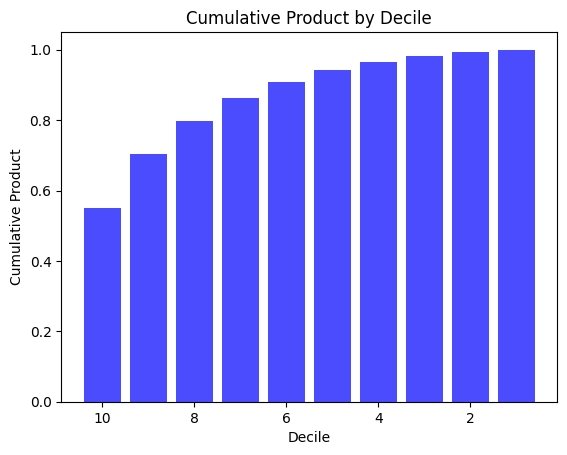

In [14]:
import matplotlib.pyplot as plt

# 棒グラフの描画
plt.bar(decil_agg['Decil_score'], decil_agg['Cumprod'], color='blue', alpha=0.7)
plt.xlabel('Decile')
plt.ylabel('Cumulative Product')
plt.title('Cumulative Product by Decile')
plt.gca().invert_xaxis() #x 軸を逆順にしています。これにより、Decil_score の値が大きい方から小さい方へとグラフが描かれます。これで x 軸を左から表示することができます。
plt.show()

## RFM分析の実装

RFM分析では、InvoiceDate, TotalPrice(デシル分析で作成したカラム), CustomerIDを使用します。

## RFM値の算出

Recencyを計算するためには、現在時刻（分析時の時刻）を指定する必要があります。購買データの最終時刻が'2011-12-09 12:50:00'であるため、今回は現在時刻（NOW）を2011年12月10日（0:00）としておきます。

In [15]:
# 履歴の最新時刻を取得
data['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [16]:
# 現時刻を設定
import datetime as dt
NOW = dt.datetime(2011,12,10)

In [17]:
# CustomerIDでGroupByし、agg関数を使ってRecency, Frequency, Monetaryを以下のように求めます。

# RFMの計算
rfm = data.groupby("CustomerID") \
    .agg({"InvoiceDate": lambda date: (NOW - date.max()).days,
          "InvoiceNo"  : lambda num: num.nunique(),
          "TotalPrice" : lambda price: price.sum()}).reset_index()

# カラム名変更
rfm.rename(columns={'InvoiceDate': 'recency',
                    'InvoiceNo'  : 'frequency',
                    'TotalPrice' : 'monetary'}, inplace=True)

rfm.head()

,CustomerID,recency,frequency,monetary
0,12346,325,1,26.00
1,12347,2,7,4060.40
2,12348,75,4,1546.68
3,12349,18,1,1757.55
4,12350,310,1,334.40


## セグメント分け

ここから、実際に算出した各指標を用いてセグメント分けしていきます。

どのように分けるか（基準値や分割数）は状況により変える必要があります、今回は各指標について四分位点を用いて分割することにします。

## 四分位点でRFMスコアを求める

In [18]:
# 以下の方法でも四分位点でRFMスコアを求めるを求めることはできる
#扱いにくかったので数値型に
# rfm['recency'] = rfm['recency'].astype(int)
# rfm['frequency'] = rfm['frequency'].astype(int)
# rfm['monetary'] = rfm['monetary'].astype(int)

# rfm['R_score'] = pd.qcut(rfm['recency'], 4, labels=['1','2','3','4']).astype(int)
# rfm['F_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=['4','3','2','1']).astype(int)
# rfm['M_score'] = pd.qcut(rfm['monetary'], 4, labels=['4','3','2','1']).astype(int)

# display(rfm)



# 以下でrank(method='first')が入っている理由
    #  └ エラーが起こるから
# rfm['F_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=['4','3','2','1']).astype(int)

# エラーが発生しているのは、pd.qcut 関数において、指定したビンの端が重複しているためです。ビンの端は一意である必要があります。
# エラーメッセージにも示されていますが、ビンの端が [1, 1, 2, 5, 211] というように、1が2回重複しています。
# これを解決するには、ビンの端を重複させないようにするか、duplicates パラメータを設定して重複を処理する必要があります。
# 例えば、ビンの端を [1, 2, 5, 211] のように設定するか、duplicates='drop' を指定して重複を削除することができます。

# # 1つ目の解決方法
# result = pd.qcut(rfm['frequency'], 4, labels=['4','3','2','1'], duplicates='drop').astype(int)

# # 2つ目の解決方法
# result = pd.qcut(rfm['frequency'], 4, labels=['4','3','2','1']).astype(int).drop_duplicates()

# どちらの方法もビンの端が一意になります。適切な解決策を選んでください。

In [19]:
#3指標それぞれの四分位点を求める
quantiles      = rfm.quantile(q=[0.25,0.5,0.75])
quantiles_dict = quantiles.to_dict()
display(quantiles_dict)

<ipython-input-19-cbcb641f6fa9>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles      = rfm.quantile(q=[0.25,0.5,0.75])


{'recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0},
 'frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'monetary': {0.25: 300.67499999999995, 0.5: 656.6899999999999, 0.75: 1601.0}}

In [20]:
# RFMを四分位点で分ける関数を定義
def cal_R(x, col, df):
    if x <= df[col][0.25]:
        return 1
    elif x <= df[col][0.50]:
        return 2
    elif x <= df[col][0.75]:
        return 3
    else:
        return 4

def cal_FM(x, col, df):
    if x <= df[col][0.25]:
        return 4
    elif x <= df[col][0.50]:
        return 3
    elif x <= df[col][0.75]:
        return 2
    else:
        return 1

In [21]:
# 各種スコアの算出
rfm['R_score'] = rfm.recency.apply(cal_R, args=('recency', quantiles_dict))
rfm['F_score'] = rfm.frequency.apply(cal_FM, args=('frequency', quantiles_dict))
rfm['M_score'] = rfm.monetary.apply(cal_FM, args=('monetary', quantiles_dict))

# ３指標を統合したスコアの算出
rfm["RFM_score"] = rfm.R_score.astype(str)+ rfm.F_score.astype(str) + rfm.M_score.astype(str)

rfm.reset_index(inplace=True)
rfm.head()

# 求めたスコアを使って、例えば「スコア4が２項目以上あれば優良顧客」などのようにセグメント分けをしていきます。

,index,CustomerID,recency,frequency,monetary,R_score,F_score,M_score,RFM_score
0,0,12346,325,1,26.00,4,4,4,444
1,1,12347,2,7,4060.40,1,1,1,111
2,2,12348,75,4,1546.68,3,2,2,322
3,3,12349,18,1,1757.55,2,4,1,241
4,4,12350,310,1,334.40,4,4,3,443


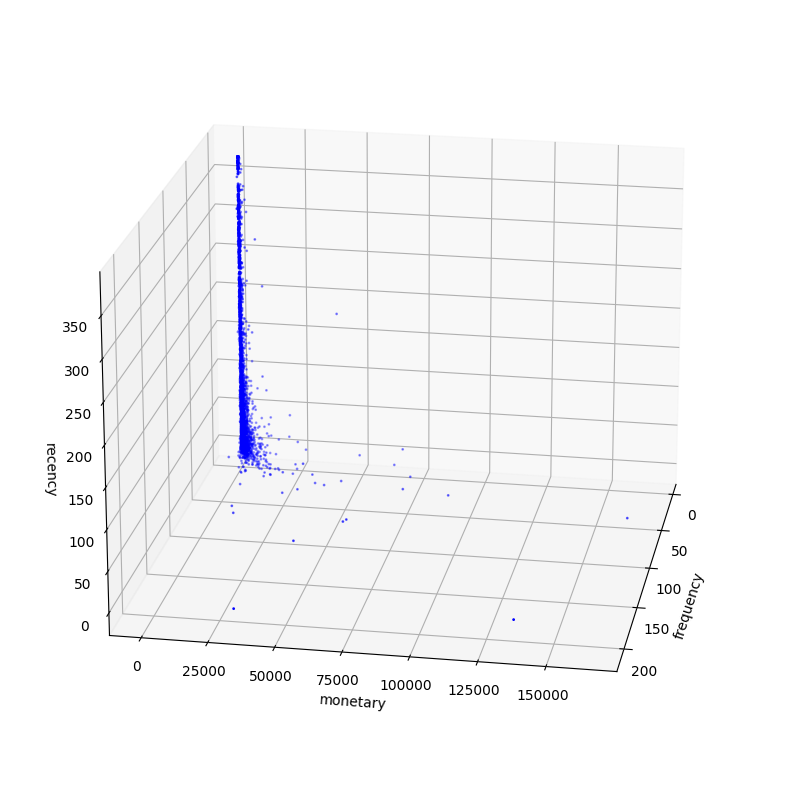

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3Dグラフを作成
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 散布図をプロット
ax.scatter(rfm['frequency'],rfm['monetary'],rfm['recency'], c='blue', marker='o', s=1)

# 軸ラベルの設定
ax.set_xlabel('frequency')
ax.set_ylabel('monetary')
ax.set_zlabel('recency')

# 3Dビューの初期設定 (azim: 水平方向の角度, elev: 垂直方向の角度)
# 以下は見たい観点別で調整する
ax.view_init(azim=10, elev=20)

# グラフ表示
plt.show()

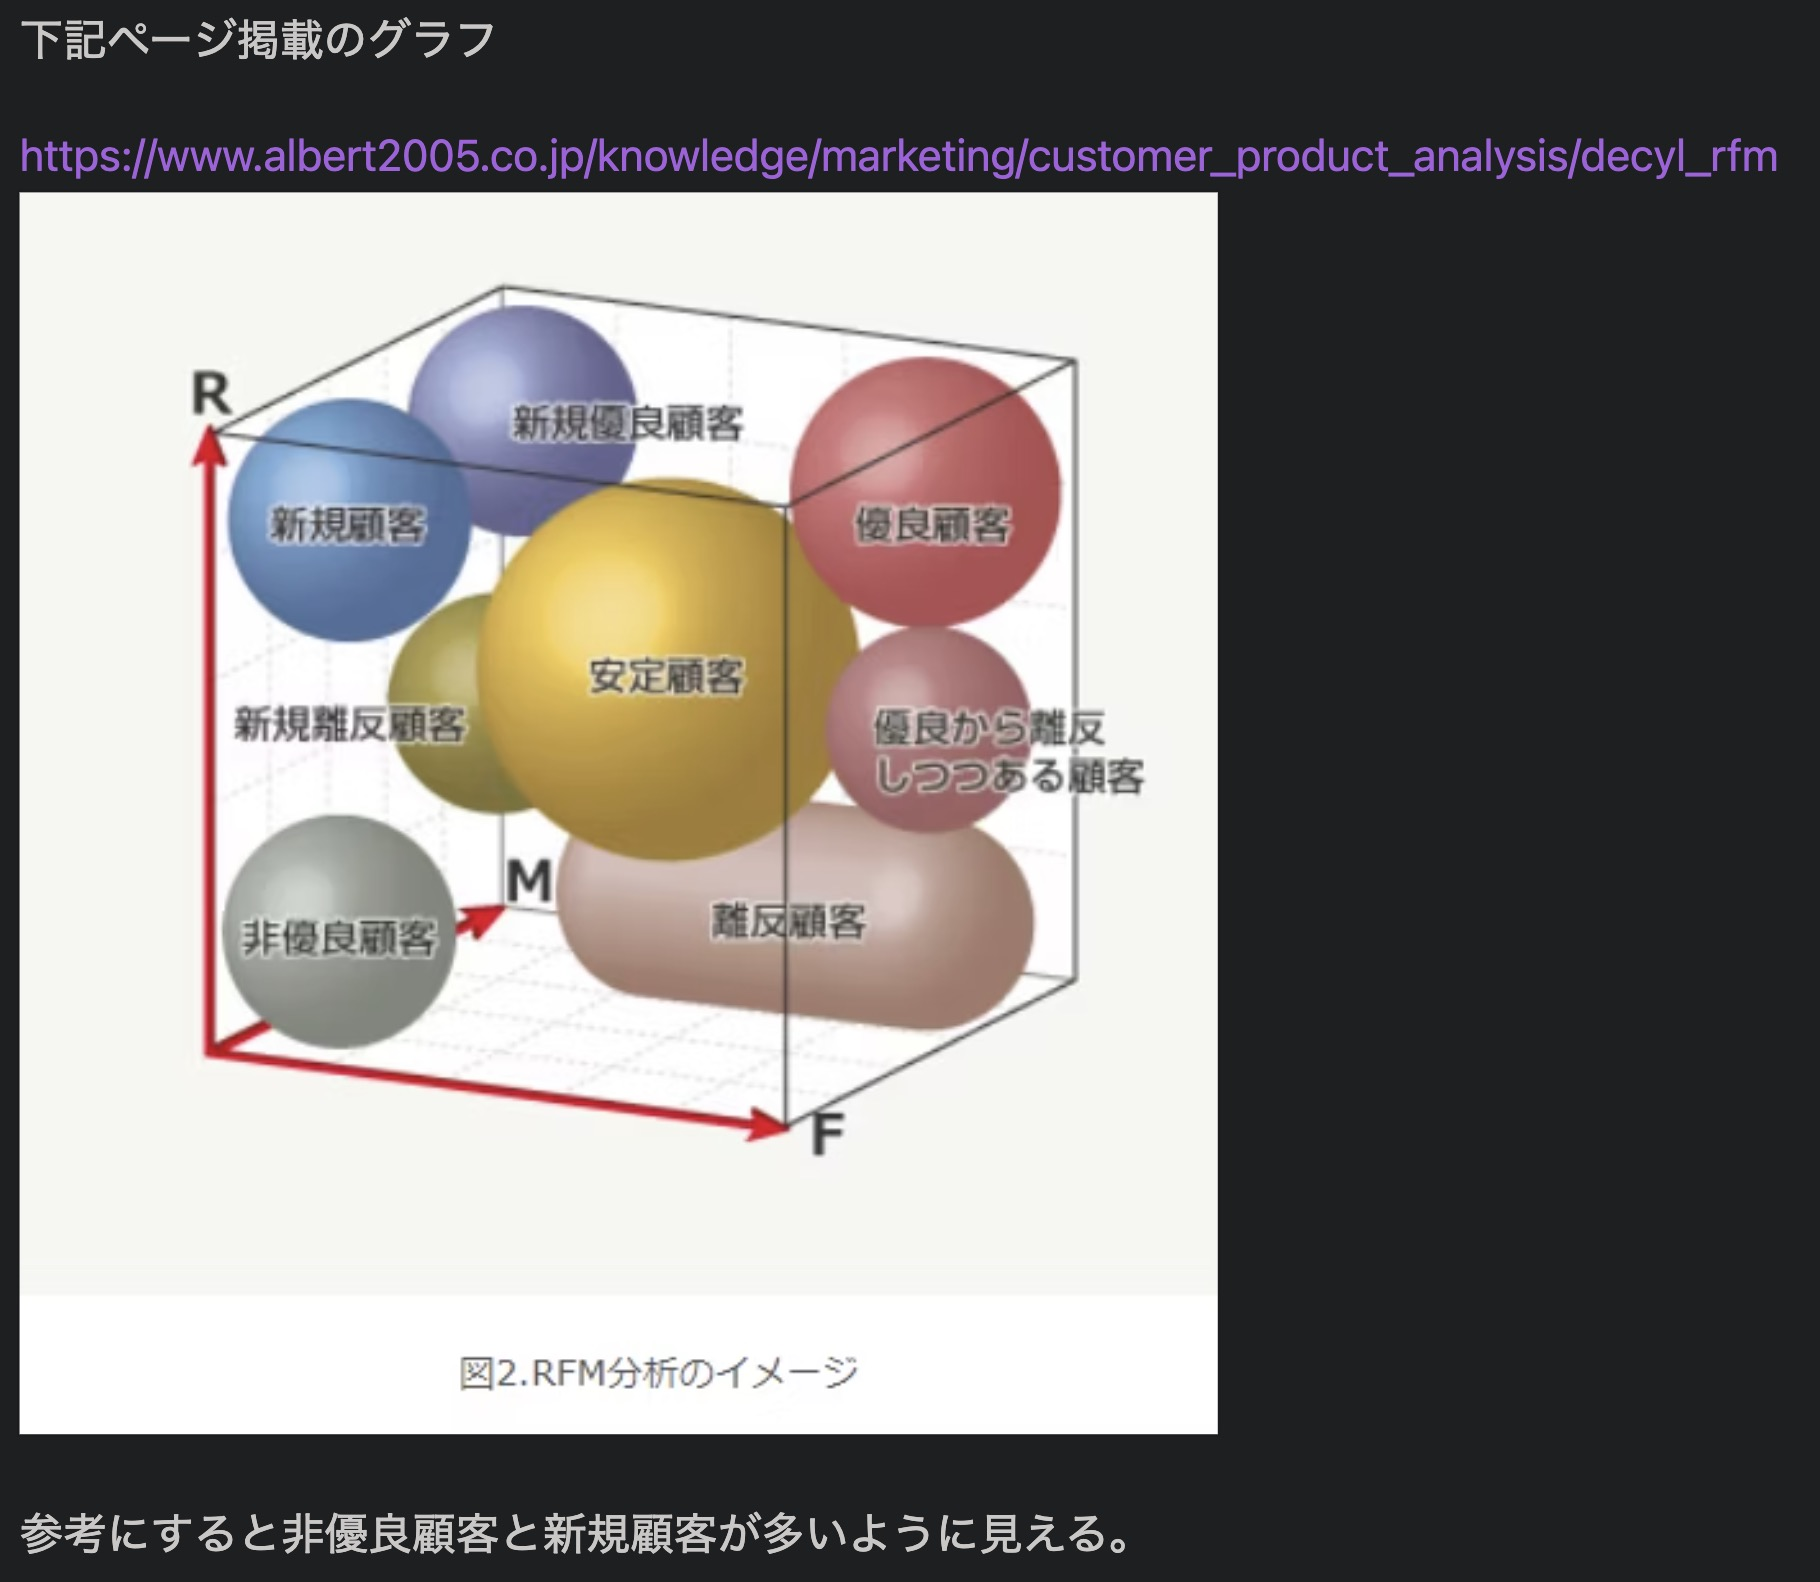

In [23]:
# 少し外れ値を考慮してみたいと思う。
q_TotalPrice = rfm.monetary.quantile(0.97)
q_TotalPrice

7400.404600000001

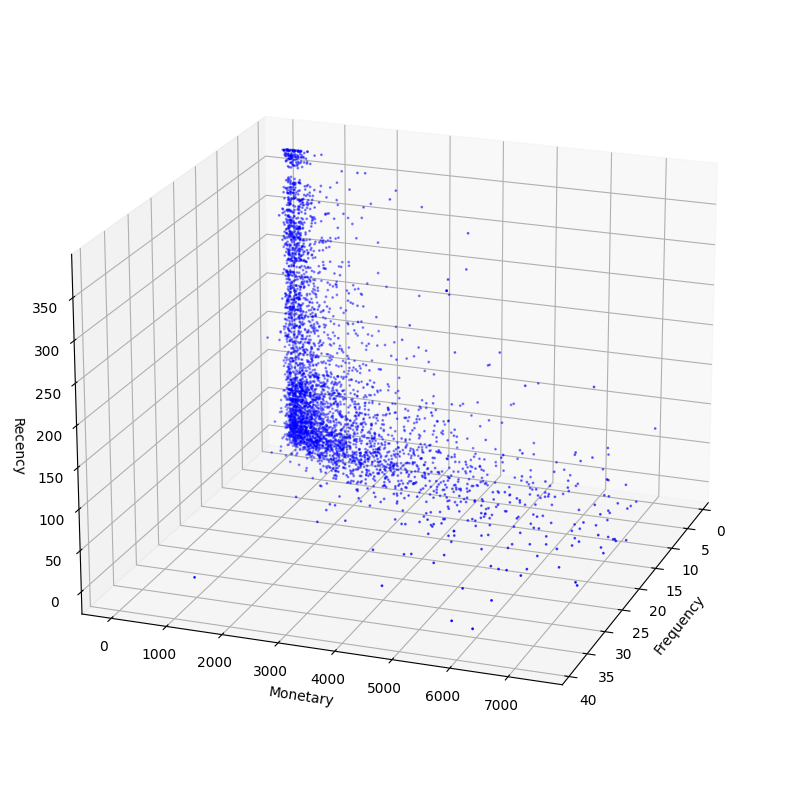

In [24]:
ex_rfm = rfm[rfm['monetary'] < q_TotalPrice]

# 3Dグラフを作成
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 散布図をプロット
ax.scatter(ex_rfm['frequency'],ex_rfm['monetary'],ex_rfm['recency'], c='blue', marker='o', s=1)

# 軸ラベルの設定
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Recency')

# 3Dビューの初期設定 (azim: 水平方向の角度, elev: 垂直方向の角度)
# 以下は見たい観点別で調整する
ax.view_init(azim=20, elev=20)

# グラフ表示
plt.show()

# 多少点が見やすくなったように思う。
# Rが大きいほど、過去日にサイトを訪問して購入を行ったユーザー。
#   └ n日以上来ていないユーザーは離反していると定義し、連絡をとってみるなどの施策を行えそう

# Fが大きいほど、何回もサイトを訪問して購入をしているユーザーだが、10あたりを堺にあまりサイトに来なくなっているみたい。
#   └ のタイミングで対象ユーザーには感謝クーポンなどを配信するなどの施策を行えそう

# Mが大きいほどサイトを訪問して購入をしてくれた金額が大きいユーザー。
#   └ このサイトでは～4000くらい購入してくれているユーザーが多いように見える。合わせ買いをしてもらえるような施策を行うことで、ユーザー全体の購入金額をUPしていきたい

## クラスタリング（k-means）

セグメント分けには、教師なしの機械学習手法（クラスタリング）を用いることもあるようです。

試しにk-means方を使ってのセグメント分けを実装してみます。

In [25]:
# 標準化
from sklearn.preprocessing import StandardScaler

tmp = rfm[['R_score', 'F_score', 'M_score']]
ss = StandardScaler()
rfm_scaled = ss.fit_transform(tmp)

display(rfm_scaled)

array([[ 1.34301118,  1.15405079,  1.34141302],
       [-1.33165772, -1.47067031, -1.34162009],
       [ 0.45145488, -0.59576328, -0.44727572],
       ...,
       [-1.33165772,  0.27914376,  1.34141302],
       [-1.33165772, -1.47067031, -1.34162009],
       [-0.44010142, -0.59576328, -1.34162009]])

分割するクラスター数は分析者が指定する必要がありますが、最適なクラスター数を考える一つの手法として、分割数を変えた時のitertia値（クラスタ内二乗誤差の和）の変化をみる方法があります。詳しくはこちらの記事がわかりやすいので是非。

url: https://qiita.com/deaikei/items/11a10fde5bb47a2cf2c2

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0, 0.5, 'Inertia Score')

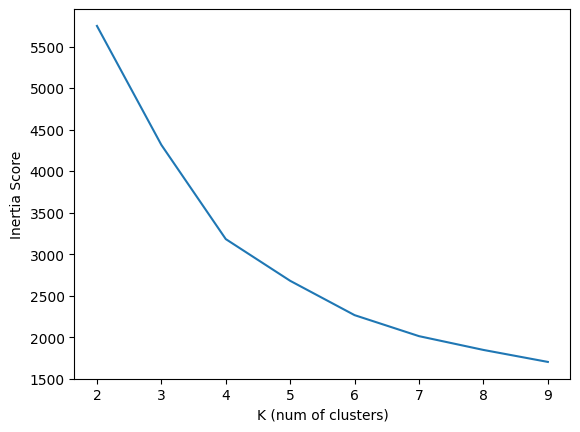

In [26]:
# クラスタリング（分割数の検討）
from sklearn.cluster import KMeans

inertias = {}
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(rfm_scaled)
    inertias[k] = km.inertia_

pd.Series(inertias).plot()
plt.xlabel("K (num of clusters)")
plt.ylabel("Inertia Score")

In [27]:
# やや判断が難しいですが、今回は4つのクラスターに分割することにします。

# k=4でクラスタリング
k = 4
km = KMeans(n_clusters=k, random_state = 1)
rfm["KMeans"] = km.fit_predict(rfm_scaled)
rfm.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,index,CustomerID,recency,frequency,monetary,R_score,F_score,M_score,RFM_score,KMeans
0,0,12346,325,1,26.00,4,4,4,444,1
1,1,12347,2,7,4060.40,1,1,1,111,0
2,2,12348,75,4,1546.68,3,2,2,322,2
3,3,12349,18,1,1757.55,2,4,1,241,2
4,4,12350,310,1,334.40,4,4,3,443,1


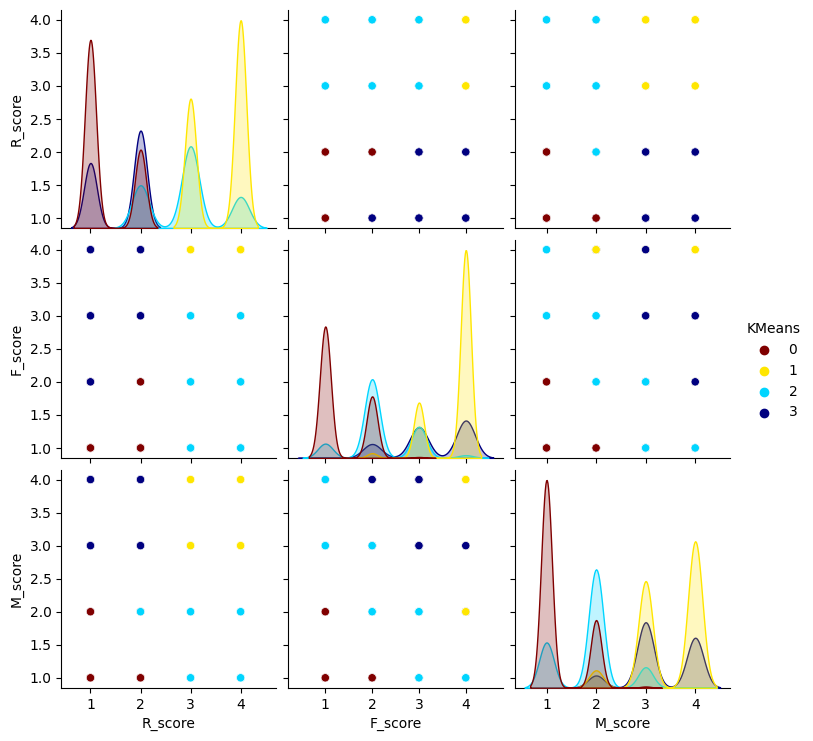

In [28]:
# 可視化
sns.pairplot(rfm[['R_score', 'F_score', 'M_score', 'KMeans']], hue="KMeans", palette='jet_r')
plt.show()

# sns.pairplotはSeabornライブラリを使用して、データフレームの変数間の散布図行列をプロットするための関数です。
# pairplotは、与えられたデータフレーム内のすべての数値変数の組み合わせについて散布図を描画し、同時に対角線上には各変数の分布をヒストグラムで表示します。

# 具体的な引数について:
# rfm[['R_score', 'F_score', 'M_score', 'KMeans']]: プロットしたいデータフレームを指定しています。この場合、R_score、F_score、M_score、KMeansの列がプロットされます。
# hue="KMeans": KMeans列の値に基づいて色分けを行います。各クラス（またはクラスタ）ごとに異なる色が使用されます。このような色分けは、データのパターンやグループの違いを視覚的に理解するのに役立ちます。
# palette='jet_r': プロットの色調を指定します。'jet_r'はMatplotlibのカラーマップの一つで、青から赤までの連続した色調を持っています。

# このコード全体は、RFMスコアとK-meansクラスタリング結果を含むデータフレームの散布図行列を描画し、各データポイントがK-meansによって異なるクラスタに分類されているかどうかを視覚的に確認するのに役立ちます。

In [29]:
# 各クラスターの要素数の確認
rfm['KMeans'].value_counts()

1    1428
0    1112
2     997
3     782
Name: KMeans, dtype: int64

# おわりに

デシル分析とRFM分析をPythonで実装してみました。Pandasの良い練習にもなりますし、やはり意味のあるデータ分析の方がモチベーションも維持しやすいと感じました。次は、商品分析に挑戦してみようと思います。

# 追加集計(pd.crosstab, pd.pivot_table)

## pd.crosstab: カテゴリーごとの出現回数を抽出

## pd.pivot_table: 平均・合計・最大など「計算」して抽出

In [30]:
rfm

,index,CustomerID,recency,frequency,monetary,R_score,F_score,M_score,RFM_score,KMeans
0,0,12346,325,1,26.00,4,4,4,444,1
1,1,12347,2,7,4060.40,1,1,1,111,0
2,2,12348,75,4,1546.68,3,2,2,322,2
3,3,12349,18,1,1757.55,2,4,1,241,2
4,4,12350,310,1,334.40,4,4,3,443,1
...,...,...,...,...,...,...,...,...,...,...
4314,4314,18280,277,1,180.60,4,4,4,444,1
4315,4315,18281,180,1,80.82,4,4,4,444,1
4316,4316,18282,7,2,178.05,1,3,4,134,3
4317,4317,18283,3,16,2094.88,1,1,1,111,0


## pd.crosstab

### url: https://smart-hint.com/python/crosstab/

In [31]:
# .reset_index()をつけることでindexで管理・分析できる

display(pd.crosstab(rfm['R_score'], rfm['F_score'], margins = True, margins_name='合計')) #RF
display(pd.crosstab(rfm['R_score'], rfm['M_score'], margins = True, margins_name='合計')) #RM
display(pd.crosstab(rfm['F_score'], rfm['M_score'], margins = True, margins_name='合計')) #FM

# normalize = False（正規化なし：実数）※デフォルト
# normalize = True（全体を合計すると1になる）
# normalize = 'all'（全体を合計すると1になる）※Trueと同じ
# normalize = 'index'（行ごとに合計すると1になる）
# normalize = 'columns'（列ごとに合計すると1になる）

display(pd.crosstab([rfm['R_score'], rfm['F_score']], rfm['M_score'], margins = True, margins_name='合計')) #RFM_multi_index
display(pd.crosstab([rfm['R_score'], rfm['F_score']], rfm['M_score'], margins = True, normalize=True, margins_name='合計')) #RFM__multi_index_normalize

display(pd.crosstab(rfm['R_score'], [rfm['F_score'], rfm['M_score']], margins = True, margins_name='合計')) #RFM_multi_columns
display(pd.crosstab(rfm['R_score'], [rfm['F_score'], rfm['M_score']], margins = True, normalize=True, margins_name='合計')) #RFM__multi_columns_normalize

F_score,1,2,3,4,合計
R_score,,,,,
1,520,319,160,99,1098
2,235,363,211,261,1070
3,92,329,235,416,1072
4,20,118,232,709,1079
合計,867,1129,838,1485,4319


M_score,1,2,3,4,合計
R_score,,,,,
1,554,281,158,105,1098
2,297,324,248,201,1070
3,181,325,312,254,1072
4,48,149,362,520,1079
合計,1080,1079,1080,1080,4319


M_score,1,2,3,4,合計
F_score,,,,,
1,725,131,9,2,867
2,294,571,225,39,1129
3,40,260,349,189,838
4,21,117,497,850,1485
合計,1080,1079,1080,1080,4319


M_score             1     2     3     4    合計
R_score F_score                              
1       1         456    58     5     1   520
        2          93   168    51     7   319
        3           5    50    70    35   160
        4           0     5    32    62    99
2       1         189    46     0     0   235
        2          92   197    67     7   363
        3          12    61    89    49   211
        4           4    20    92   145   261
3       1          67    23     2     0    92
        2          92   156    71    10   329
        3          12    91    92    40   235
        4          10    55   147   204   416
4       1          13     4     2     1    20
        2          17    50    36    15   118
        3          11    58    98    65   232
        4           7    37   226   439   709
合計               1080  1079  1080  1080  4319

M_score                 1         2         3         4        合計
R_score F_score                                                  
1       1        0.105580  0.013429  0.001158  0.000232  0.120398
        2        0.021533  0.038898  0.011808  0.001621  0.073860
        3        0.001158  0.011577  0.016207  0.008104  0.037046
        4        0.000000  0.001158  0.007409  0.014355  0.022922
2       1        0.043760  0.010651  0.000000  0.000000  0.054411
        2        0.021301  0.045612  0.015513  0.001621  0.084047
        3        0.002778  0.014124  0.020607  0.011345  0.048854
        4        0.000926  0.004631  0.021301  0.033573  0.060431
3       1        0.015513  0.005325  0.000463  0.000000  0.021301
        2        0.021301  0.036119  0.016439  0.002315  0.076175
        3        0.002778  0.021070  0.021301  0.009261  0.054411
        4        0.002315  0.012734  0.034036  0.047233  0.096319
4       1        0.003010  0.000926  0.000463  0.000232  0.004631
        2        0.003936  0.011577  0.008335  0.003473  0.027321
        3        0.002547  0.013429  0.022690  0.015050  0.053716
        4        0.001621  0.008567  0.052327  0.101644  0.164158
合計               0.250058  0.249826  0.250058  0.250058  1.000000

F_score    1               2                 3                  4            \
M_score    1    2  3  4    1    2    3   4   1    2    3    4   1    2    3   
R_score                                                                       
1        456   58  5  1   93  168   51   7   5   50   70   35   0    5   32   
2        189   46  0  0   92  197   67   7  12   61   89   49   4   20   92   
3         67   23  2  0   92  156   71  10  12   91   92   40  10   55  147   
4         13    4  2  1   17   50   36  15  11   58   98   65   7   37  226   
合計       725  131  9  2  294  571  225  39  40  260  349  189  21  117  497   

F_score         合計  
M_score    4        
R_score             
1         62  1098  
2        145  1070  
3        204  1072  
4        439  1079  
合計       850  4319

F_score         1                                       2                      \
M_score         1         2         3         4         1         2         3   
R_score                                                                         
1        0.105580  0.013429  0.001158  0.000232  0.021533  0.038898  0.011808   
2        0.043760  0.010651  0.000000  0.000000  0.021301  0.045612  0.015513   
3        0.015513  0.005325  0.000463  0.000000  0.021301  0.036119  0.016439   
4        0.003010  0.000926  0.000463  0.000232  0.003936  0.011577  0.008335   
合計       0.167863  0.030331  0.002084  0.000463  0.068071  0.132207  0.052095   

F_score                   3                                       4            \
M_score         4         1         2         3         4         1         2   
R_score                                                                         
1        0.001621  0.001158  0.011577  0.016207  0.008104  0.000000  0.001158   
2        0.001621  0.002778  0.014124  0.020607  0.011345  0.000926  0.004631   
3        0.002315  0.002778  0.021070  0.021301  0.009261  0.002315  0.012734   
4        0.003473  0.002547  0.013429  0.022690  0.015050  0.001621  0.008567   
合計       0.009030  0.009261  0.060199  0.080806  0.043760  0.004862  0.027090   

F_score                            合計  
M_score         3         4            
R_score                                
1        0.007409  0.014355  0.254226  
2        0.021301  0.033573  0.247743  
3        0.034036  0.047233  0.248206  
4        0.052327  0.101644  0.249826  
合計       0.115073  0.196805  1.000000

## pd.pivot_table

### url: https://smart-hint.com/python/pivot_table/

In [32]:
# .reset_index()をつけることでindexで管理・分析できる

display(pd.pivot_table(rfm, index='R_score', values='F_score', aggfunc = 'count', margins=True, margins_name='合計'))
display(pd.pivot_table(rfm, index='R_score', values='M_score', aggfunc = 'count', margins=True, margins_name='合計'))
display(pd.pivot_table(rfm, index='F_score', values='M_score', aggfunc = 'count', margins=True, margins_name='合計'))

# 以下のaggfuncの引数
# mean：平均
# sum：合計
# max：最大値
# min：最小値
# count：件数

display(pd.pivot_table(rfm, index=['R_score','F_score'], values='M_score', aggfunc = ('count','sum','min','max','mean')))
display(pd.pivot_table(rfm, index=['R_score','F_score'], values='M_score', aggfunc = 'count', margins=True, margins_name='合計'))

display(pd.pivot_table(rfm, index=['R_score'], values=['M_score','F_score'], aggfunc = ('count','sum','min','max','mean')))
display(pd.pivot_table(rfm, index=['R_score'], values=['M_score','F_score'], aggfunc = 'count', margins=True, margins_name='合計'))

,F_score
R_score,
1,1098
2,1070
3,1072
4,1079
合計,4319


,M_score
R_score,
1,1098
2,1070
3,1072
4,1079
合計,4319


,M_score
F_score,
1,867
2,1129
3,838
4,1485
合計,4319


count  max      mean  min   sum
R_score F_score                                 
1       1          520    4  1.136538    1   591
        2          319    4  1.912226    1   610
        3          160    4  2.843750    1   455
        4           99    4  3.575758    2   354
2       1          235    2  1.195745    1   281
        2          363    4  1.969697    1   715
        3          211    4  2.829384    1   597
        4          261    4  3.448276    1   900
3       1           92    3  1.293478    1   119
        2          329    4  1.996960    1   657
        3          235    4  2.680851    1   630
        4          416    4  3.310096    1  1377
4       1           20    4  1.550000    1    31
        2          118    4  2.415254    1   285
        3          232    4  2.935345    1   681
        4          709    4  3.547250    1  2515

M_score
R_score F_score         
1       1            520
        2            319
        3            160
        4             99
2       1            235
        2            363
        3            211
        4            261
3       1             92
        2            329
        3            235
        4            416
4       1             20
        2            118
        3            232
        4            709
合計                  4319

F_score                         M_score                        
          count max      mean min   sum   count max      mean min   sum
R_score                                                                
1          1098   4  1.852459   1  2034    1098   4  1.830601   1  2010
2          1070   4  2.465421   1  2638    1070   4  2.329907   1  2493
3          1072   4  2.909515   1  3119    1072   4  2.596082   1  2783
4          1079   4  3.510658   1  3788    1079   4  3.254866   1  3512

,F_score,M_score
R_score,,
1,1098,1098
2,1070,1070
3,1072,1072
4,1079,1079
合計,4319,4319
